<a href="https://colab.research.google.com/github/quarcs-lab/pysal-datasets/blob/master/301_weights_taz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Weights: Case Study

- [Introduction](#Introduction)
- [Data](#Data)
- [TAZ Contiguity](#Construct-a-Rook-contiguity-weight)
- [Counties as sets](#Counties-as-sets)
- [Block weights](#Block-weights)
- [Intersection weights](#Intersection-weights)

## Introduction
This notebook illustrates the use of PySAL weights in preparing input to a
spatial optimization model. It makes use of the `set-theoretic` functionality
that the weights class affords.

The researcher is building an optimization model to partition traffic analysis
zones (TAZs) subject to contiguity constraints and a boundary condition, such
that flows between TAZs assigned to the same group are maximized, but flows
cannot cross specified boundaries. The problem facing the research is to develop
a representation of neighbor relations as input to the spatial optimization
model.

In [1]:
! pip install -q libpysal
! pip install -q esda
! pip install -q mapclassify
! pip install -q splot
! pip install -q geopandas


     |████████████████████████████████| 2.4MB 4.3MB/s 
     |████████████████████████████████| 71kB 2.9MB/s 
     |████████████████████████████████| 962kB 9.1MB/s 
     |████████████████████████████████| 266kB 23.0MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 14.7MB 303kB/s 
     |████████████████████████████████| 10.9MB 35.9MB/s 
     |████████████████████████████████| 235kB 37.1MB/s 


In [2]:
import numpy as np
import libpysal 
import random as rdm
import geopandas as gpd
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Clone entire Github repository
!git clone -l -s git://github.com/quarcs-lab/pysal-datasets.git cloned-repo
# Change working directory to cloned-repo
%cd cloned-repo
# Show contents of repo
#!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1765 (delta 9), reused 26 (delta 2), pack-reused 1727
Receiving objects: 100% (1765/1765), 229.63 MiB | 24.21 MiB/s, done.
Resolving deltas: 100% (666/666), done.
Checking out files: 100% (2846/2846), done.
/content/cloned-repo


## Data
The data under consideration is a set of *Traffic Analysis Zones* (TAZs) in Southern California.
We first read these in and visualize the context:

In [6]:
shp = gpd.read_file("taz/taz-master/taz.shp")
shp.head()

,AREA,PERIMETER,CNTY,RSA,AIRDB,TAZ2K,SQ_MILE,ACRE,NEWSEQ,CSA,CSA_NEW,SQMI_TAZ,TAZ_NUM,CountyFIPS,geometry
0,3.063184e+09,243171.125,5,31,9,501030005,1182.68,756920.29,3884,900,0,1182.697393,501030005,5,"POLYGON ((559589.338 3961300.567, 564857.251 3..."
1,3.523131e+09,279249.313,5,31,9,500890100,1360.27,870578.15,3878,900,0,1360.283134,500890100,5,"POLYGON ((505502.460 3961256.872, 505483.472 3..."
2,5.587425e+09,319885.094,5,31,9,501030001,2157.29,1380675.24,3881,900,0,2157.308384,501030001,5,"POLYGON ((505502.460 3961256.872, 506399.372 3..."
3,6.799230e+09,376757.563,5,31,9,501030000,2625.13,1680092.40,3885,900,0,2625.186791,501030000,5,"POLYGON ((645688.682 3941581.368, 645775.559 3..."
4,2.598151e+09,270201.500,5,32,7,501160000,1003.14,642015.54,3956,0,256,1003.147789,501160000,5,"POLYGON ((504605.181 3903234.961, 504490.180 3..."


(247555.4738695356, 788748.4256152901, 3591645.390108616, 3981320.303239247)

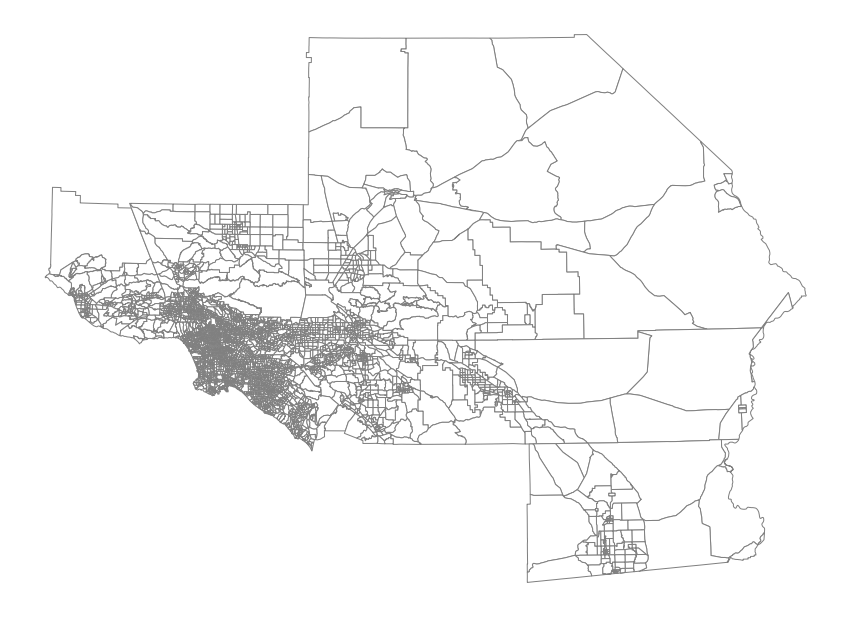

In [7]:
shp.plot(figsize=(15,15),color='white', edgecolor='grey')
plt.axis('off')

### Construct a Rook contiguity weight
The researcher first needs to define the adjacency relations between the TAZs. Here the *rook* criterion is used:

In [8]:
wrook = libpysal.weights.Rook.from_dataframe(shp)

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [9]:
def w2line_graph(w, shp):
    segments = []
    centroids = shp.centroid.values
    for i in w.id2i:
        origin = np.array(centroids[i].coords)[0] 
        for j in w.neighbors[i]:
            dest = np.array(centroids[j].coords)[0]
            ij = [i,j]
            ij.sort()
            segments.append([origin, dest])

    return segments    

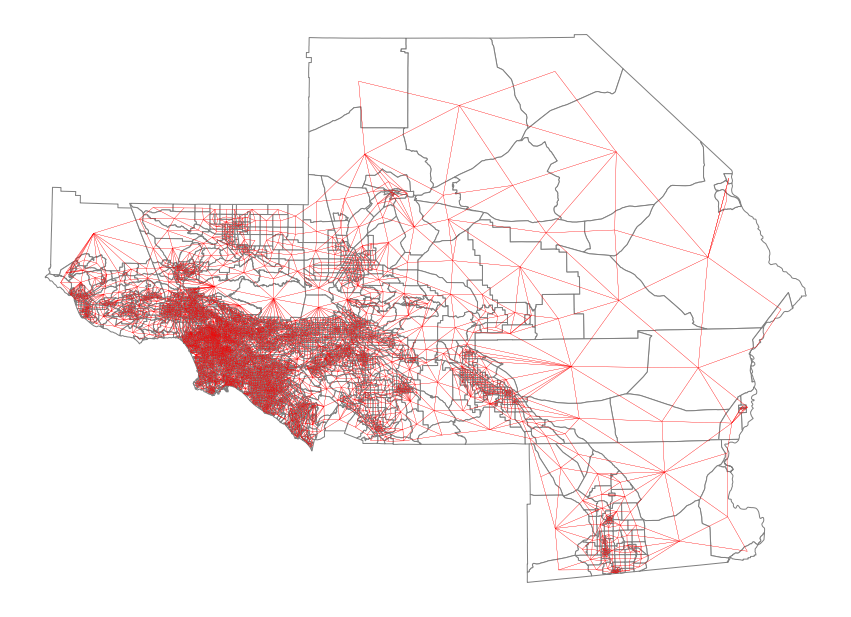

In [10]:
segs = w2line_graph(wrook, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

We can zoom into a more dense area of the region by setting the view limits on the axis object:

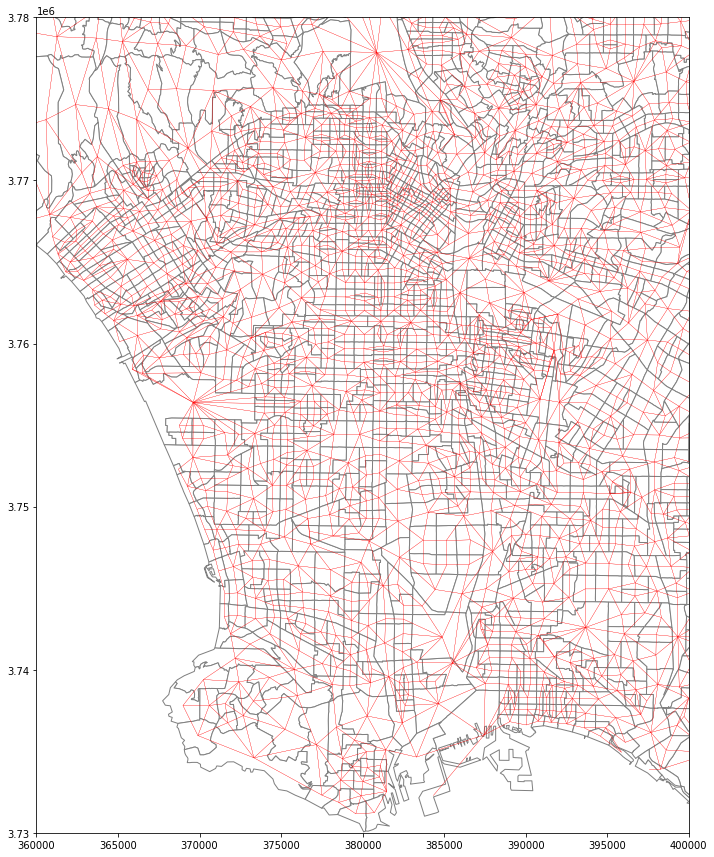

In [11]:
segs = w2line_graph(wrook, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
_ = ax.set_xlim(360000, 400000)
_ = ax.set_ylim(3730000, 3780000)

#ax.set_axis_off()

Note that we have commented out the call to turn the axis off. 

## Counties as sets
The county boundaries are going to play the role of the sets. 

In [12]:
shp["CNTY"].describe()

count    4109.000000
mean        2.865904
std         1.266095
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         6.000000
Name: CNTY, dtype: float64

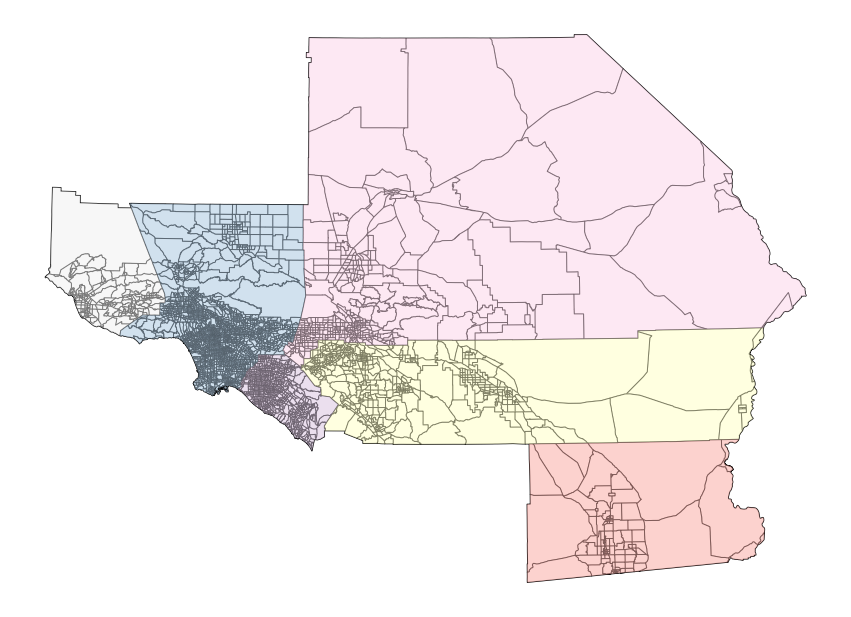

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax,color='white', edgecolor='black')
shp.plot(column="CNTY", ax=ax, categorical=True,cmap="Pastel1",alpha=0.6)
ax.set_axis_off()

## Block weights

As we learned previously, block weights use a *regime variable* that partitions the observations into exhaustive and mutually exclusive groups. All members belonging to the same group are treated as pair-wise neighbors.

In [14]:
libpysal.weights.block_weights?

Given this, we can use the `CNTY` attribute as our membership variable:

In [15]:
wb = libpysal.weights.block_weights(shp["CNTY"])

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


Notice the warning about 6 disconected components. This is definitely a feature here, as the model precludes TAZs from different counties forming a neighbor pair.

Examining the block weight, we learn that it is much more dense than
 than the simple rook contiguity graph:

In [16]:
print(wb.pct_nonzero, wrook.pct_nonzero)

35.04398070562094 0.12978058776889034


## Intersection weights

We now have two weights objects that we can use to arrive at the desired neighbor graph. The rook weights object defines all TAZs that share an edge, including those pairs belonging to different counties. We want all of these pairs with the exception of the latter. The block weights define as neighbors all pairs of TAZs belonging to the same county. The intersection of these two weights objects will give us what we need:

In [17]:
wint = libpysal.weights.w_intersection(wb, wrook)

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


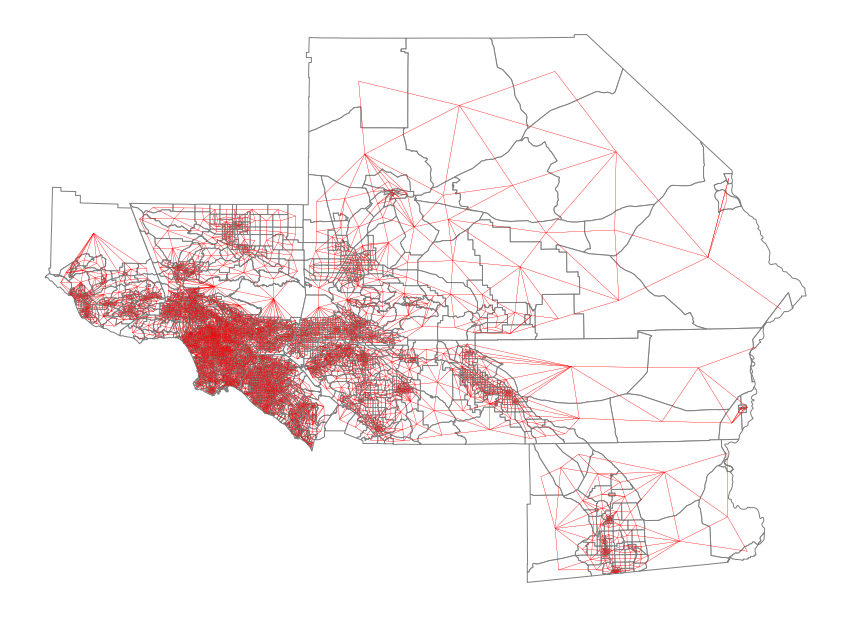

In [18]:
segs = w2line_graph(wint, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

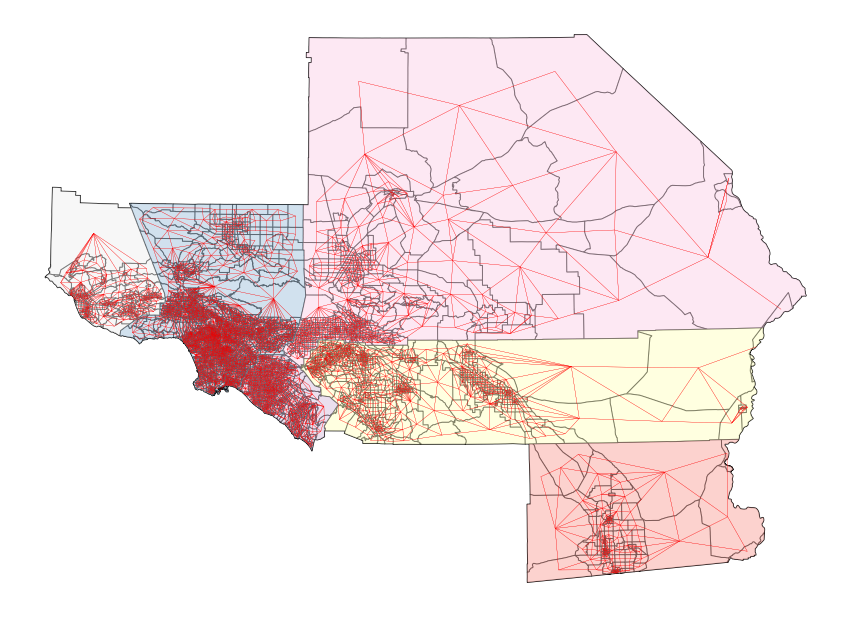

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax,color='white', edgecolor='black')
shp.plot(column="CNTY", ax=ax, categorical=True,cmap="Pastel1",alpha=0.6)
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Spatial Weights: Case Study</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.